In [167]:
from scipy.io import loadmat
annots = loadmat("results/Gore_Range_Albers_2000m/Gore_Range_Albers_2000m_kernel_x4.mat")

In [2]:
k = annots["Kernel"]
k.shape

(45, 45)

In [ ]:
!pip install matplotlib

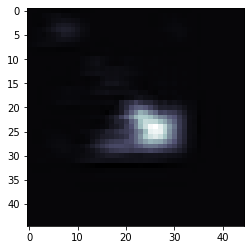

In [3]:
import matplotlib.pyplot as plt
plt.imshow(k, cmap="bone")

In [11]:
type(k)

numpy.ndarray

In [4]:
import rasterio as rio
import numpy as np

dem = rio.open("../../Dataset/Gore_Range_Albers_2000m.asc").read(1).astype('float64')

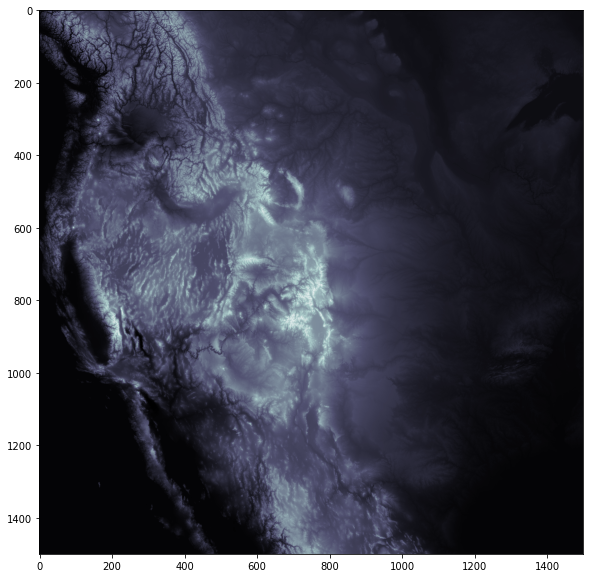

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(dem, cmap="bone")

In [21]:
k.shape

(23, 23)

In [133]:
from scipy.ndimage import correlate

def numeric_kernel(im, kernel, scale_factor, output_shape, kernel_shift_flag):
    # See kernel_shift function to understand what this is
    if kernel_shift_flag:
        kernel = kernel_shift(kernel, scale_factor)

    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    out_im = correlate(im, kernel)
    # print(out_im.shape)
    #print(np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None].shape)
    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None],
           np.round(np.linspace(0, im.shape[1] - 1 / scale_factor[1], output_shape[1])).astype(int)]

In [179]:
def psnr(a, b):
    L = 10500.0
    # L = a.max()-a.min()
    rmse = np.sqrt(np.square(a - b).sum()) +1e-10
    # print(rmse)
    return 20.0 * np.log10((L)/(rmse))

In [16]:
def normalize(im):
    MIN_H = -500.0
    MAX_H = 10000.0
    return (im - MIN_H)/(MAX_H-MIN_H)

In [62]:
%%time
dem = rio.open("../../Dataset/Gore_Range_Albers_2000m.asc").read(1).astype('float64')
k = loadmat("results/Gore_Range_Albers_2000m/Gore_Range_Albers_2000m_kernel_x4.mat")["Kernel"]
down_scaled_x2 = numeric_kernel(dem, k, [0.25,0.25], (375, 375), False)  
#down_scaled_x4 = numeric_kernel(dem, k, [0.25,0.25], (375, 375), False)  

(375, 1)
CPU times: user 6.4 s, sys: 15.9 ms, total: 6.41 s
Wall time: 6.49 s


In [49]:
psnr(out, out)

3589.253229776202


/tmp/ipykernel_12012/1220382284.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  return 20.0 * np.log10((L-1)/(rmse))


inf

In [59]:
psnr(out, down_scaled_x2)

17799.929087142347


-4.585406728247738

In [32]:
(out - down_scaled_x2).sum()

-3413025.4179269923

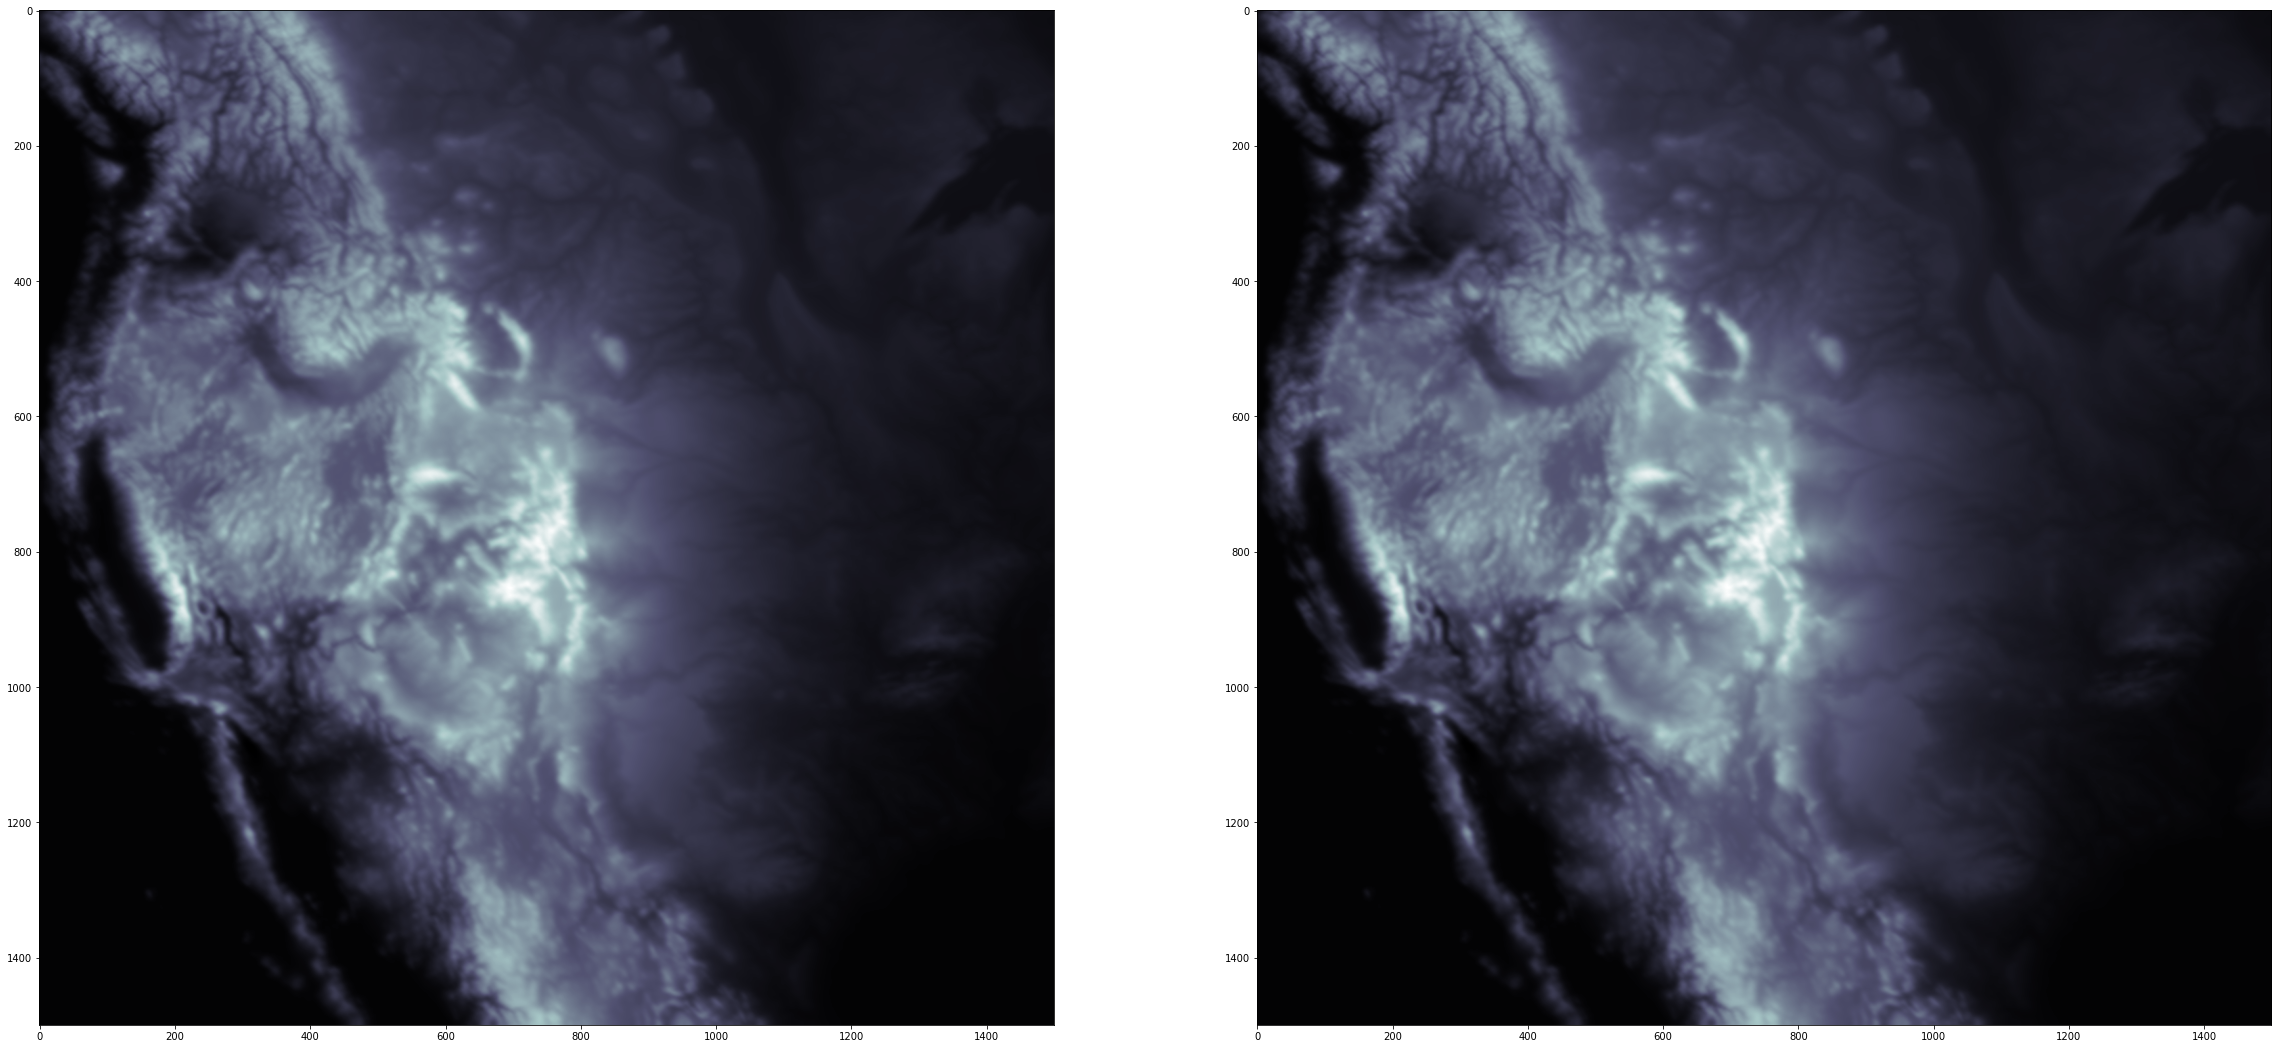

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(40,20))
# plt.figure()
ax[0].imshow(down_scaled_x2, cmap="bone")
ax[1].imshow(out, cmap="bone")

In [ ]:
!pip install torchvision

### Defining the metrics

In [163]:
from ignite.metrics import PSNR,SSIM
from ignite.engine import Engine
import torch
from imresize import numeric_kernel

In [181]:


def eval_step(engine, batch): 
    return batch 
def calculate_error(img1,img2):
    
    default_evaluator = Engine(eval_step)
    # converting np ndarray->torch tensor
    y1 =  torch.from_numpy(img1).unsqueeze(0).unsqueeze(0)
    y2 =  torch.from_numpy(img2).unsqueeze(0).unsqueeze(0)

    # calculating PSNR 
    psnr = PSNR(data_range=10500)
    psnr.attach(default_evaluator,'psnr')
    state1 = default_evaluator.run([[y1,y2]])
    print(f"PSNR :{state1.metrics['psnr']}")

    # # calculating SSIM
    y1,y2 = torch.tensor(y1,dtype=torch.float32),torch.tensor(y2,dtype=torch.float32)
    metric = SSIM(data_range=img1.max()-img1.min())
    metric.attach(default_evaluator, 'ssim')
    state2 = default_evaluator.run([[y1, y2]])


    # print(f"SSIM : {state2.metrics['ssim']}")

In [169]:
%%time
dem = rio.open("/Users/mohammadkashif/Desktop/SIH/Dataset/Bryce_Canyon.asc").read(1).astype('float64')
k = loadmat("/Users/mohammadkashif/Desktop/SIH/kernels/Bryce_Canyon_kernel_x2.mat")["Kernel"]
down_scaled_x2 = numeric_kernel(dem, k, [0.25,0.25], (375, 375), False)  
down_scaled_x4 = numeric_kernel(dem, k, [0.5,0.5], (375, 375), False)  

CPU times: user 12.5 s, sys: 117 ms, total: 12.6 s
Wall time: 12.6 s


In [185]:
calculate_error(down_scaled_x4,down_scaled_x2)

PSNR :80.82637820990998


In [186]:
psnr(down_scaled_x4,down_scaled_x2)

29.34575285582965

### Dataset Definition

In [112]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

In [ ]:
import os

class DemDataset(Dataset):
    """DEM dataset."""

    def __init__(self, root_dir, kernel_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the DEMs.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.demList = os.listdir(os.path.abspath(root_dir))
        self.kernel_dir = kernel_dir
        #print(self.demList)

    def __len__(self):
        return len(self.demList)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.demList[idx])
        
        k = self.get_Kernel()
        
        # image = io.imread(img_name)
        im = rio.open(img_name).read(1).astype('float')
        HR = RandomCrop(im, 256)
        LR = numeric_kernel(HR, k, [0.25,0.25], (64, 64), False) 
        #print(type(LR))
        if self.transform:
            HR = self.transform(HR)
            LR = self.transform(LR)
            
        sample = {'HR': HR, 'LR': LR}

        return sample
    
    def get_Kernel(self): 
        kernels = os.listdir(self.kernel_dir)
        i = np.random.randint(0, len(kernels))
        k_path = os.path.join(self.kernel_dir, kernels[i])
        k = loadmat(k_path)["Kernel"]

        return k
    
    def RandomCrop(self,image, output_size):
        h, w = image.shape[:2]
        new_h, new_w = (output_size, output_size)

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        return image

In [151]:
data = DemDataset("../../Dataset/", "results/Gore_Range_Albers_250m", transform = transforms.Compose([transforms.ToTensor()]))
dl = DataLoader(dataset=data, batch_size=16, shuffle=True)

In [152]:
data[0]

{'HR': tensor([[[102.7000, 112.4000, 110.6000,  ..., 114.9000, 136.7000,  43.3000],
          [108.8000, 124.6000, 111.8000,  ...,  88.8000, 108.8000,  36.6000],
          [119.1000, 127.0000, 110.0000,  ...,  68.2000,  91.2000,  39.7000],
          ...,
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,   0.2000],
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,   0.2000],
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,   0.2000]]],
        dtype=torch.float64),
 'LR': tensor([[[111.2442, 112.6885, 120.5019,  ...,  88.1183,  83.6161,  85.2746],
          [111.9599, 113.4698, 120.6320,  ..., 100.5043, 102.4546, 108.0505],
          [113.4597, 113.4995, 116.8769,  ..., 106.8262, 111.4634, 117.9517],
          ...,
          [  0.2000,   0.2000,   0.2000,  ...,   0.2006,   0.1993,   0.2008],
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,   0.2000],
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,  

In [153]:
for i_batch, sample_batched in enumerate(dl):
    print(i_batch, sample_batched['LR'].size(), sample_batched['HR'].size())

0 torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 256, 256])
1 torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 256, 256])
2 torch.Size([3, 1, 64, 64]) torch.Size([3, 1, 256, 256])


### Testing noise patches


In [131]:
def noise_patch(img, sp, max_var, min_mean):
    img = np.array(img)

    w, h = img.shape
    collect_patchs = []

    for i in range(0, w - sp, sp):
        for j in range(0, h - sp, sp):
            patch = img[i:i + sp, j:j + sp]
            var_global = np.var(patch)
            mean_global = np.mean(patch)
            print(var_global,mean_global)
            if var_global < max_var and mean_global > min_mean:
                collect_patchs.append(patch)

    return collect_patchs

In [116]:
import numpy as np

In [117]:
from PIL import Image
img = Image.open('cat_img.jpeg')
img = np.array(img)


In [144]:
import rasterio as rio
img = rio.open('/Users/mohammadkashif/Desktop/SIH/Dataset/Bryce_Canyon.asc').read(1).astype('float64')


In [145]:
type(img)

numpy.ndarray

In [127]:
img.std(),img.mean()

(110.6051881149287, 2348.6816798983446)

In [120]:
img.max()-img.min()

454.555908203125

In [156]:
patchs = noise_patch(img,256,10,0)

In [157]:
p = np.array(patchs)
p.shape

(4, 256, 256)

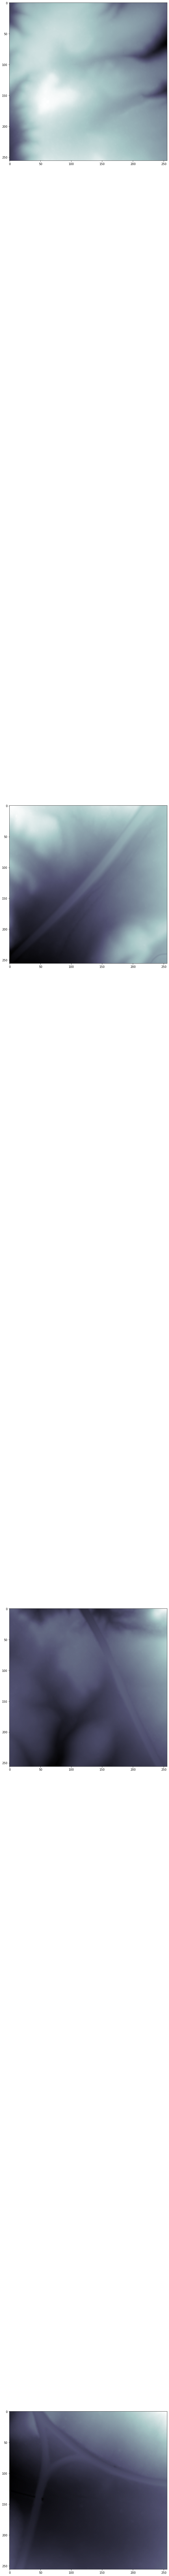

In [158]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(p.shape[0], 1, figsize=(10,200))
for i in range(p.shape[0]):
    ax[i].imshow(p[i],cmap='bone')

In [159]:
data = np.load('/Users/mohammadkashif/Desktop/SIH/Noise_patch/10.npy')
data.shape

(221, 221)

In [161]:
data.max(),data.min()

(1165.5269775390625, 1107.3160400390625)

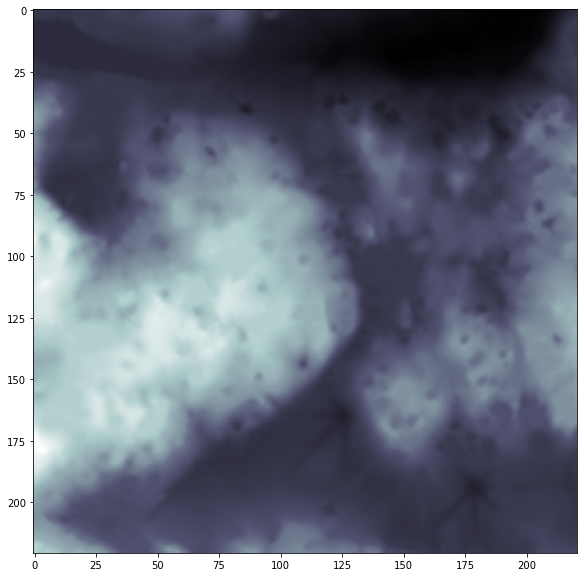

In [160]:
plt.figure(figsize=(20,10))
plt.imshow(data, cmap="bone")

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
cap = cv.imread()
# create a list of first 5 frames
img = [cap.read()[1] for i in range(5)]
# convert all to grayscale
gray = [cv.cvtColor(i, cv.COLOR_BGR2GRAY) for i in img]
# convert all to float64
gray = [np.float64(i) for i in gray]
# create a noise of variance 25
noise = np.random.randn(gray[1].shape)10
# Add this noise to images
noisy = [i+noise for i in gray]
# Convert back to uint8
noisy = [np.uint8(np.clip(i,0,255)) for i in noisy]
# Denoise 3rd frame considering all the 5 frames
dst = cv.fastNlMeansDenoisingMulti(noisy, 2, 5, None, 4, 7, 35)
plt.subplot(131),plt.imshow(gray[2],'gray')
plt.subplot(132),plt.imshow(noisy[2],'gray')
plt.subplot(133),plt.imshow(dst,'gray')
plt.show()